<a href="https://colab.research.google.com/github/DataScienceUB/DeepLearningMaster2019/blob/master/13.%20Reinforcement%20learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Reinforcement Learning

> *Reinforcement learning is an area of machine learning inspired by behaviorist psychology, concerned with how software agents ought to take **actions in an environment** so as to maximize some notion of **cumulative reward**. (Source: Wikipedia)*

Reinforcement learning provides the capacity for us not only to teach an artificial agent how to act, but to allow it to learn through it’s own interactions with an environment. 

By combining the complex representations that deep neural networks can learn with the goal-driven learning of an RL agent, computers have accomplished some amazing feats, like beating humans at over a dozen Atari games, and defeating the Go world champion.

RL algorithms must enable the agent to learn the correct pairings itself through the use of *observations*, *rewards*, and *actions*.

Typical aspects of a task that make it an RL problem are the following:
1. Different actions yield different rewards. For example, when looking for treasure in a maze, going left may lead to the treasure, whereas going right may lead to a pit of snakes.
2. Rewards are delayed over time. This just means that even if going left in the above example is the right things to do, we may not know it till later in the maze.
3. Reward for an action is conditional on the state of the environment. Continuing the maze example, going left may be ideal at a certain fork in the path, but not at others.


## Multi-armed bandit

The simplest reinforcement learning problem is the multi-armed bandit. Essentially, there are $n$-many slot machines, each with a different fixed payout probability. 

The goal is to discover the machine with the best payout, and maximize the returned reward by always choosing it. 

<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/slot.jpg?raw=1" alt="" style="width: 400px;"/>

This question has been the subject of active research since the 1950s, and many variations have been studied.

#### A-B Testing

Traditional A-B testing can be thought of as a special case of the multi-armed bandit problem, in which we choose to pursue a strategy of pure exploration in the initial testing phase, followed by a period of pure exploitation in which we choose the most valuable “arm” 100% of the time.

If the exploitation phase can be assumed to be much longer than the exploration phase, this approach is usually reasonable, as the wasted resources during the exploration are insignificant relative to the total rewards. However, in cases where the cost of the exploration phase is non-negligible, or in cases in which arm values are changing dynamically on short enough timescales that it becomes impractical to repeatedly perform new A-B tests, alternative approaches are needed.

The n-armed bandit is a nice starting place because we don’t have to worry about aspects #2 and #3. All we need to focus on is learning which rewards we get for each of the possible actions, and ensuring we chose the optimal ones.

### Epsilon-greedy

The most straightforward algorithm for continuously balancing exploration with exploitation is called “epsilon-greedy”. 

Here, we pull a randomly chosen arm a fraction $\epsilon$ of the time. The other $1-\epsilon$ of the time, we pull the arm which we estimate to be the most profitable. As each arm is pulled and rewards are received, our estimates of arm values are updated. 

This method can be thought of a a continuous testing setup, where we devote a fraction $\epsilon$ of our resources to testing.

The following python code implements a simple 10-Armed Bandit using the epsilon-greedy algorithm. 

The payout rate of the arms are normally distributed with $\mu = 0$ and $\sigma = 1$. Gaussian noise is also added to the rewards, also with $\mu = 0$ and $\sigma = 1$. (See [Sutton and Barto](http://people.inf.elte.hu/lorincz/Files/RL_2006/SuttonBook.pdf) book, section 2.1)

In [0]:
import numpy as np 
import seaborn 
from tqdm import tqdm

class Bandit: 
    def __init__(self): 
        self.arm_values = np.random.normal(0,1,10) #arm values
        self.K = np.zeros(10)                      #action counter
        self.est_values = np.zeros(10)             #estimated values

    def get_reward(self,action):                   #get noisy reward from machine "action"
        noise = np.random.normal(0,1) 
        reward = self.arm_values[action] + noise 
        return reward 

    def choose_eps_greedy(self,epsilon):           #exploitation or exploration decision
        rand_num = np.random.random() 
        if epsilon>rand_num: 
            return np.random.randint(10)           #exploration
        else: 
            return np.argmax(self.est_values)      #exploitation

    def update_est(self,action,reward):            #estimation of the value of an action
        self.K[action] += 1 
        alpha = 1./self.K[action] 
        self.est_values[action] += alpha * (reward - self.est_values[action]) 
        
a= Bandit()
print("The arm vales of the 10 machines are: \n",a.arm_values)
print("The reward if we play first machine is: \n",a.get_reward(0))


The arm vales of the 10 machines are: 
 [ 1.1796864   0.40726757  0.31826565  0.75944305  0.44926722  1.04328852
  0.31688177 -0.20897799 -1.0835095   0.67392407]
The reward if we play first machine is: 
 2.366974080810383


How are we estimating the value of an action?

If by the $t$-th time step action $a$ has been chosen $K_a$ times prior to $t$, yielding rewards 
$R_1, R_2, . . . , R_{Ka}$, then its value is estimated to be:

$$
Q_t(a) = \frac{R_1 + R_2 + . . .+ R_{Ka}}{K_a}
$$

A problem with this straightforward implementation is that its memory and computational requirements grow over time without
bound (we have to maintain, for each action $a$, a record of all the rewards that have followed the
selection of that action), but we can derive an incremental formula for computing averages with small, constant computation
required to process each new reward.

\begin{eqnarray*}
Q_{k+1} & = & \frac{1}{k+1} \sum_{i=1}^{k+1} R_i \\
  & = & \frac{1}{k+1} \left( R_{k+1} + \sum_{i=1}^k R_i
\right) \\
  & = & \frac{1}{k+1} \left( R_{k+1} + kQ_k + Q_k - Q_k
\right) \\
  & = & \frac{1}{k+1} \left(R_{k+1} + (k+1) Q_k - Q_k
\right) \\
  & = & Q_k + \frac{1}{k+1} \left( R_{k+1} - Q_k \right)
\end{eqnarray*}



In [0]:
def experiment(bandit,Npulls,epsilon):
    history = [] 
    for i in range(Npulls): 
        action = bandit.choose_eps_greedy(epsilon)
        R = bandit.get_reward(action) 
        bandit.update_est(action,R) 
        history.append(R) 
    return np.array(history)

Let's make three different experiments: $\epsilon = 0$, $\epsilon = 0.1$ and $\epsilon = 0.01$. Data will be averages over 2000 tasks.

100%|██████████| 2000/2000 [03:35<00:00,  9.35it/s]


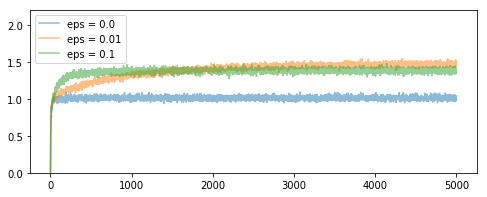

In [0]:
Nexp = 2000
Npulls = 5000 
avg_outcome_eps0p0 = np.zeros(Npulls) 
avg_outcome_eps0p01 = np.zeros(Npulls) 
avg_outcome_eps0p1 = np.zeros(Npulls) 

for i in tqdm(range(Nexp)): 
    bandit = Bandit() 
    avg_outcome_eps0p0 += experiment(bandit,Npulls,0.0) 
    bandit = Bandit() 
    avg_outcome_eps0p01 += experiment(bandit,Npulls,0.01) 
    bandit = Bandit() 
    avg_outcome_eps0p1 += experiment(bandit,Npulls,0.1) 

avg_outcome_eps0p0 /= np.float(Nexp) 
avg_outcome_eps0p01 /= np.float(Nexp) 
avg_outcome_eps0p1 /= np.float(Nexp) 

# plot results 
import matplotlib.pyplot as plt 

plt.plot(avg_outcome_eps0p0,label="eps = 0.0", alpha=0.5) 
plt.plot(avg_outcome_eps0p01,label="eps = 0.01", alpha=0.5) 
plt.plot(avg_outcome_eps0p1,label="eps = 0.1", alpha=0.5) 
plt.ylim(0,2.2) 
plt.legend() 
plt.gcf().set_size_inches((8,3))
plt.show()

Although ε-greedy action selection is an effective and popular means of balancing exploration and exploitation in reinforcement learning, one drawback is that when it explores **it chooses equally among all actions**. 

This means that it is as likely to choose the worst-appearing action as it is to choose the next-to-best action. In tasks where the worst actions are very bad, this may
be unsatisfactory. The obvious solution is to vary the action probabilities as a graded function of estimated value.

The greedy action will be given the highest selection probability, but all the others will be ranked and weighted according to
their value estimates. To this end we can use a softmax action selection rule (with a temperature parameter $\tau$):

$$
\frac{ e^{Q_t(a)/ \tau}}{\sum_{i=1}^n e^{Q_t(i)/ \tau}}
$$

For high temperatures ( $\tau \to \infty $ ), all actions have nearly the same probability. For a low temperature ( $ \tau \to 0^{+} $), the probability of the action with the highest expected reward tends to 1.

### Contextual Bandit

In the bandit problem described above, it is assumed that **nothing is known about each arm other than what we have learned from prior pulls**.

We can relax this assumption and assume that for each arm there is a d-dimensional “context” vector. For example, if each arm represents a digital ad, the features in these vectors may correspond to things like banner size, web browser type, font color, etc. We can now model the value of each arm using these context vectors as well as past rewards in order to inform our choice of which arm to pull. This scenario is known as the contextual bandit problem.

## Q-learning

Unlike other methods, which attempt to learn functions which directly map an observation to an action, Q-Learning attempts **to learn the value of being in a given state, and taking a specific action there**. 

The agent is in a state $s$ and has to choose one action $a$, upon which it receives a reward $r$ and come to a new state $s’$. The way the agent chooses actions is called **policy**.

Let’s define a function $Q(s, a)$ such that for given state $s$ and action $a$ it returns an estimate of a total reward we would achieve starting at this state, taking the action and then following some policy. Under certain conditions, there certainly exist policies that are optimal, meaning that they always select an action which is the best in the context. Let’s call the $Q$ function for these optimal policies $Q^*$.

If we knew the true $Q^*$ function, the solution would be straightforward. We would just apply a greedy policy to it. That means that in each state $s$, we would just choose an action $a$ that maximizes the function $Q^*$, $argmax_a Q^*(s, a)$. Knowing this, our problem reduces to find a good estimate of the $Q^*$ function and apply the greedy policy to it.

Let’s write a formula for this function in a symbolic way. It is a sum of rewards we achieve after each action, but we will discount every member with γ:

 $$ Q^*(s, a) = r_0 + \gamma r_1 + \gamma^2 r_2 + \gamma^3 r_3 + ... $$

$\gamma$ is called a discount factor and when set it to $\gamma < 1$ , it makes sure that the sum in the formula is finite. Value of each member exponentially diminish as they are more and more in the future and become zero in the limit. The $\gamma$ therefore controls how much the function $Q$ in state $s$ depends on the future and so it can be thought of as how much ahead the agent sees. 

Typically we set it to a value close, but lesser to one. The actions are chosen according to the greedy policy, maximizing the $Q^*$ function.

When we look again at the formula, we see that we can write it in a recursive form:

 $$Q^*(s, a) = r_0 + \gamma (r_1 + \gamma r_2 + \gamma^2 r_3 + ...) = r_0 + \gamma max_a Q^*(s', a)$$
 
We just derived a so called **Bellman equation**.
 
One of the possible strategies to solve the Bellman equation is by applying the **Q-learning** algorithm:

```
For each state-action pair (s, a), initialize the table entry Q(s,a) to zero
Observe the current state s
Do forever:
- Select an action a from s and execute it 
- Receive immediate reward r
- Observe the new state s'
- Update the table entry for Q
- s=s'
```
#### Action selection

We could apply different strategies for action selection:
+ **Random approach**. Only in circumstances where a random policy is optimal would this approach be ideal.
+ **$\epsilon$- greedy approach**:  A simple combination of the greedy and random approaches yields one of the most used exploration strategies. At the start of the training process the $\epsilon$ value is often initialized to a large probability, to encourage exploration in the face of knowing little about the environment. The value is then annealed down to a small constant (often 0.1), as the agent is assumed to learn most of what it needs about the environment. Despite the prevalence of usage that it enjoys, this method is far from optimal, since it takes into account only whether actions are most rewarding or not.
+ **Boltzmann Approach**. Instead of always taking the optimal action, or taking a random action, this approach involves choosing an action with weighted probabilities. To accomplish this we use a softmax over the networks estimates of value for each action.  In practice we utilize an additional temperature parameter ($\tau$) which is annealed over time. While this measure can be a useful proxy, it is not exactly what would best aid exploration. What we really want to understand is the agent’s uncertainty about the value of different actions.
+ **Bayesian Approaches**. What if an agent could exploit its own uncertainty about its actions? This is exactly the ability that a class of neural network models referred to as Bayesian Neural Networks (BNNs) provide. Unlike traditional neural network which act deterministically, BNNs act probabilistically. This means that instead of having a single set of fixed weights, a BNN maintains a probability distribution over possible weights. In a reinforcement learning setting, the distribution over weight values allows us to obtain distributions over actions as well. The variance of this distribution provides us an estimate of the agent’s uncertainty about each action. In order to get true uncertainty estimates, multiple samples are required, thus increasing computational complexity.


#### Table updating

The table entry for $Q$ is updated by using this formula:

$$
Q(s,a) = Q(s,a) + \alpha [r + \gamma max_{a'} Q(s',a') - Q(s,a) ]
$$

where 

+ $0<\alpha<1$ is the learning rate. Setting it to 0 means that the Q-values are never updated, hence nothing is learned. Setting a high value such as 0.9 means that learning can occur quickly.
+ $0<\gamma<1$ is the discount factor. This models the fact that future rewards are worth less than immediate rewards. 

See http://www.scholarpedia.org/article/Temporal_difference_learning for a short description.

### Solving the FrozenLake problem

We are going to to solve the FrozenLake environment from the OpenAI gym. 

OpenAI gym (https://gym.openai.com/) provides an easy way for people to experiment with their learning agents in an array of provided toy games. The FrozenLake environment consists of a 4x4 grid of blocks, each one either being the start block, the goal block, a safe frozen block, or a dangerous hole. 

> **FrozenLake-v0**

> The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

> The surface is described using a grid like the following:

>``SFFF       (S: starting point, safe)``

>``FHFH       (F: frozen surface, safe)``

>``FFFH       (H: hole, fall to your doom)``

>``HFFG       (G: goal, where the frisbee is located)``

> The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.

The objective is to have an agent learn to navigate from the start to the goal without moving onto a hole. At any given time the agent can choose to move either ``up, down, left``, or ``right``. 

The catch is that there is a wind which occasionally blows the agent onto a space they didn’t choose. As such, perfect performance every time is impossible, but learning to avoid the holes and reach the goal are certainly still doable. The reward at every step is 0, except for entering the goal, which provides a reward of 1. Thus, we will need an algorithm that learns long-term expected rewards. This is exactly what Q-Learning is designed to provide.

In it’s simplest implementation, Q-Learning is a table of values for every state (row) and action (column) possible in the environment. Within each cell of the table, we learn a value for how good it is to take a given action within a given state. 

In the case of the FrozenLake environment, we have 16 possible states (one for each block), and 4 possible actions (the four directions of movement), giving us a $16 \times 4$ table of Q-values. We start by initializing the table to be uniform (all zeros), and then as we observe the rewards we obtain for various actions, we update the table accordingly.

In [0]:
import gym
import numpy as np
env = gym.make('FrozenLake-v0')

In [0]:
#Initialize table with all zeros
Q = np.zeros([env.observation_space.n,env.action_space.n])

# Set learning parameters
lr = .9
gamma = 0.95
num_episodes = 10000

#create lists to contain total rewards and steps per episode
rList = []

for i in range(num_episodes):
    #Reset environment and get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    
    #The Q-Table learning algorithm
    while j < 999999:
        j+=1
        #Choose an action by greedily (with noise) picking from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        #Get new state and reward from environment
        s1,r,d,_ = env.step(a)
        #Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + lr*(r + gamma*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
    rList.append(rAll)
    
print("Score over time: " +  str(sum(rList[-100:])/100))
print("Final Q-Table Values")
print(Q)

Score over time: 0.8
Final Q-Table Values
[[1.70216414e-01 9.91289589e-04 8.07651609e-04 9.94384986e-04]
 [3.11849273e-05 2.41157068e-04 2.23941046e-04 3.10609046e-01]
 [2.52090813e-01 1.00321309e-04 1.47766959e-04 6.91033227e-04]
 [6.06716105e-04 6.52081250e-04 7.59932127e-05 6.45606522e-04]
 [6.93535446e-02 1.41301294e-04 6.20534292e-04 2.38752473e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.77946039e-07 8.62823977e-08 1.47888298e-01 4.44273898e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.79765630e-05 1.62084109e-04 5.82167070e-06 5.55430222e-02]
 [2.78345654e-05 6.73250716e-01 6.70158380e-05 1.85569486e-05]
 [9.11405139e-01 8.56105056e-06 1.65664270e-06 2.37234780e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.98543694e-01 0.00000000e+00]
 [0.00000000e+00 9.57241931e-01 0.00000000e+00 5.06933574e-03]
 [0.00000000e

FrozenLake-v0 is considered "solved" when the agent obtains an average reward of at least 0.78 over 100 consecutive episodes.

## Q-Learning with Neural Networks

Now, you may be thinking: tables are great, but they don’t really scale, do they? While it is easy to have a 16x4 table for a simple grid world, the number of possible states in any modern game or real-world environment is nearly infinitely larger. For most interesting problems, tables simply don’t work. 

We instead need some way to take a description of our state, and produce $Q$-values for actions without a table: that is where neural networks come in. By acting as a function approximator, we can take any number of possible states that can be represented as a vector and learn to map them to $Q$-values.

<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/pong.jpg?raw=1" alt="" style="width: 300px;"/>


In the case of the FrozenLake example, we will be using a one-layer network which takes the state encoded in a one-hot vector (1x16), and produces a vector of 4 $Q$-values, one for each action. 

Such a simple network acts kind of like a glorified table, with the network weights serving as the old cells. The key difference is that we can easily expand the Tensorflow network with added layers, activation functions, and different input types, whereas all that is impossible with a regular table. 

The method of updating is a little different as well. 

Instead of directly updating our table, with a network we will be using backpropagation and a loss function. Our loss function will be sum-of-squares loss, where the difference between the current predicted $Q$-values, and the “target” value is computed and the gradients passed through the network. 

In this case, our $Q_{target}$ for the chosen action is the equivalent to the $Q$-value computed in equation above ($
Q(s,a) + \alpha [r + \gamma max_{a'} Q(s',a') - Q(s,a) ]
$).

$$
Loss = \sum (Q_{target} - Q_{predicted})^2
$$

In [0]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('FrozenLake-v0')

In [0]:
tf.reset_default_graph()

#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
init = tf.global_variables_initializer()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000

#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],
                              feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,
                          feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],
                            feed_dict={inputs1:np.identity(16)[s:s+1],
                                       nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print("Percent of succesful episodes: " + str(sum(rList[-100:])/100) + "%")

Percent of succesful episodes: 0.66%


We can see that the network beings to consistly reach the goal around the 400 episode mark.

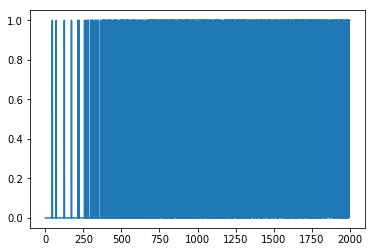

In [0]:
plt.plot(rList)

It also begins to progress through the environment for longer than chance around the 600 mark as well.

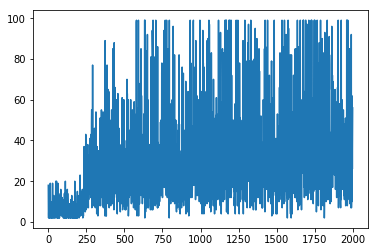

In [0]:
plt.plot(jList)

## Deep Q-networks

While our ordinary Q-network was able to barely perform as well as the Q-Table in a simple game environment, Deep $Q$-Networks are much more capable. In order to transform an ordinary Q-Network into a DQN we will be making the following improvements:
+ Going from a single-layer network to a multi-layer convolutional network.
+ Implementing Experience Replay, which will allow our network to train itself using stored memories from it’s experience.
+ Utilizing a second “target” network, which we will use to compute target $Q$-values during our updates.

<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/deepq1.png?raw=1" alt="" style="width: 800px;"/>


See https://jaromiru.com/2016/09/27/lets-make-a-dqn-theory/

### Convolutional Layers

Since our agent is going to be learning to play video games, it has to be able to make sense of the game’s screen output in a way that is at least similar to how humans or other intelligent animals are able to. Instead of considering each pixel independently, convolutional layers allow us to consider regions of an image, and maintain spatial relationships between the objects on the screen as we send information up to higher levels of the network.

### Experience Replay

The second major addition to make DQNs work is Experience Replay. 

The problem with online learning is that the *samples arrive in order* they are experienced and as such are highly correlated. Because of this, our network will most likely overfit and fail to generalize properly.

The key idea of **experience replay** is that we store these transitions in our memory and during each learning step, sample a random batch and perform a gradient descend on it. 

The Experience Replay buffer stores a fixed number of recent memories, and as new ones come in, old ones are removed. When the time comes to train, we simply draw a uniform batch of random memories from the buffer, and train our network with them. 

### Separate Target Network

This second network is used to generate the $Q$-target values that will be used to compute the loss for every action during training. 

The issue is that at every step of training, the $Q$-network’s values shift, and if we are using a constantly shifting set of values to adjust our network values, then the value estimations can easily spiral out of control. The network can become destabilized by falling into feedback loops between the target and estimated $Q$-values. In order to mitigate that risk, the target network’s weights are fixed, and only periodically or slowly updated to the primary $Q$-networks values. In this way training can proceed in a more stable manner.

Instead of updating the target network periodically and all at once, we will be updating it frequently, but slowly.

While the DQN we have described above could learn ATARI games with enough training, getting the network to perform well on those games takes at least a day of training on a powerful machine.

## Other examples

https://www.youtube.com/watch?v=gn4nRCC9TwQ

https://www.youtube.com/watch?v=wBrwN4dS-DA

https://www.youtube.com/watch?v=n7370dzCZ1o

https://www.youtube.com/watch?v=fv-oFPAqSZ4

https://www.youtube.com/watch?time_continue=33&v=tXlM99xPQC8